### 물류의 최적화 경로
: 물류의 최적 경로를 컨설팅하는 테크닉 10

당신은 어떤 기업의 창고에 있습니다. 
1) 그 창고에는 1만 개의 상품 재고가 보관되어 있습니다. 
2) 상품은 전국 대리점에서 판매됩니다. 
3) 이 기업은 이 창고뿐만 아니라 전국에 창고가 흩어져 있습니다. 
4) 더 복잡한 것은 전국 여러 공장에서 생산된 상품이 각각의 창고에 도착한다는 사실입니다.             
> 이렇게 전국으로 상품을 판매하는 기업에게 어디에서 어느 정도의 상품을 생산하고 어느 창고에 재고를 보관하고 어느 대리점에 몇 개의 상품을 배송하는가 하는 '물류'(물건의 흐름 제어)는 상품의 매출을 좌우하는 생명선이라고 할 수 있습니다.

'물류'의 개념은 대리점뿐 아니라 많은 업계에 응용할 수 있습니다. 
1. 보험 회사라면 영업 사원이 어떤 경로로 영업해야 하는지
2. 택시 회사라면 어떤 경로에 각각의 택시를 배차할 것인가의 계획에 이용할 수 있습니다. 

이 장에서는 '물류'의 기초가 되는 '운송최적화'를 검토하고 기초적인 기술을 배웁니다. 
> 실제 물류 데이터로부터 <b><u>네트워크 구조를 가시화하는 방법을 배우고 최적 물류 계획을 세우</b></u>는 흐름을 배웁니다.

고객의 소리) 우리 회사는 제품의 제조에서 물류까지 도맡아 하고 있습니다. 최근 회사 이익이 감소하고 있어 <b><u>물류비용을 줄이고 효율화</b></u>를 생각하고 있습니다. 먼저 제품의 부품을 보관하는 창고에서 생산 공장까지 운송 비용을 낮출 수 있을지 분석을 부탁드립니다.

[전제조건]             
북부 지사와 남부 지사의 데이터를 시스템에서 추출해 CSV로 제공합니다.      
                          
집계 기간) 2019년 1월 1일 ~ 2019년 12월 31일             
                    
tbl_factory.csv : 생산 공장 데이터            
tbl_warehouse.csv : 창고 데이터            
rel_cost.csv : 창고와 공장 간의 운송 비용              
tbl_transaction.csv : 2019년의 공장으로의 부품 운송 실적        

#### 1. 데이터 불러오기

* 각 FCID, WHID, RCostID, TRID는 키

In [1]:
# 물류 데이터 불러오기
import pandas as pd

factory = pd.read_csv('./data/tbl_factory.csv', index_col= 0)
factory.head()

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,서울공장,28,북부
FC00002,수원공장,29,북부
FC00003,인천공장,31,북부
FC00004,대전공장,25,북부
FC00005,대구공장,21,남부


In [2]:
warehouse = pd.read_csv('./data/tbl_warehouse.csv', index_col= 0)
warehouse.head()

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,판교창고,35,북부
WH00002,용인창고,41,북부
WH00003,수원창고,42,북부
WH00004,대전창고,60,남부
WH00005,대구창고,72,남부


In [3]:
trans_cost = pd.read_csv('./data/rel_cost.csv', index_col= 0)
trans_cost.head()

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [4]:
transaction = pd.read_csv('./data/tbl_transaction.csv', index_col= 0)
transaction.head()

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


데이터 분석의 기초가 될 데이터는 운송 실적이므로 이를 중심으로 정보를 결합

In [5]:
total_trans_cost = trans_cost.merge(right= factory, how= 'left', on= 'FCID')
total_trans_cost.head()

total_trans_cost = total_trans_cost.merge(right= warehouse, how= 'left', on= 'WHID')
total_trans_cost.head()

total_transaction = transaction.merge(total_trans_cost, how= 'left', 
                                      left_on= ['ToFC', 'FromWH'], right_on= ['FCID', 'WHID'])

total_transaction.head()
# total_transaction = total_transaction[['TransactionDate', 'ToFC', 'FromWH', 'Quantity', 'Cost', 
#                                        'FCID', 'FCName', 'FCDemand', 'FCRegion',
#                                        'WHID', 'WHName', 'WHSupply', 'WHRegion']]

total_transaction = total_transaction[['TransactionDate','Quantity', 'Cost', 
                                       'ToFC', 'FCName', 'FCDemand', 'FCRegion',
                                       'FromWH', 'WHName', 'WHSupply', 'WHRegion']] # FCID, WHID 제외

total_transaction.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FCRegion,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,대전공장,25,북부,WH00003,수원창고,42,북부
1,2019-01-01 06:12:42,19,1.3,FC00007,부산공장,25,남부,WH00006,광주창고,65,남부
2,2019-01-01 06:32:32,31,0.9,FC00006,광주공장,30,남부,WH00004,대전창고,60,남부
3,2019-01-01 07:17:06,18,1.6,FC00002,수원공장,29,북부,WH00003,수원창고,42,북부
4,2019-01-01 07:52:18,30,0.8,FC00001,서울공장,28,북부,WH00002,용인창고,41,북부


>> 북부 지사와 남부 지사 비교

In [6]:
north = total_transaction.loc[total_transaction['WHRegion'] == '북부']
north.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FCRegion,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,대전공장,25,북부,WH00003,수원창고,42,북부
3,2019-01-01 07:17:06,18,1.6,FC00002,수원공장,29,북부,WH00003,수원창고,42,북부
4,2019-01-01 07:52:18,30,0.8,FC00001,서울공장,28,북부,WH00002,용인창고,41,북부
7,2019-01-01 09:09:30,12,1.5,FC00001,서울공장,28,북부,WH00003,수원창고,42,북부
8,2019-01-01 10:52:55,27,1.5,FC00003,인천공장,31,북부,WH00003,수원창고,42,북부


In [7]:
south = total_transaction.loc[total_transaction['WHRegion'] == '남부']
south.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FCRegion,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,부산공장,25,남부,WH00006,광주창고,65,남부
2,2019-01-01 06:32:32,31,0.9,FC00006,광주공장,30,남부,WH00004,대전창고,60,남부
5,2019-01-01 08:56:09,31,0.3,FC00005,대구공장,21,남부,WH00005,대구창고,72,남부
6,2019-01-01 09:00:15,33,0.7,FC00006,광주공장,30,남부,WH00006,광주창고,65,남부
9,2019-01-01 14:12:51,21,0.7,FC00006,광주공장,30,남부,WH00006,광주창고,65,남부


데이터 불러오기와 가공이 완료됐습니다.                     
다음 테크닉에서 실제 운송량과 비용을 확인하고 지사 간 비교를 해봅시다.

>> 현재의 운송량과 비용 확인

- 남북부 지사별 1년간 운송한 부품 수와 비용을 집계

In [8]:
print('북부 운송 비용 :', north['Cost'].sum(), '만원')
print('남부 운송 비용 :', south['Cost'].sum(), '만원')

북부 운송 비용 : 2189.3 만원
남부 운송 비용 : 2062.0 만원


In [9]:
print('북부 부품 총 운송 갯수 : ' + str(north['Quantity'].sum()) + '개')
print('남부 부품 총 운송 갯수 : ' + str(south['Quantity'].sum()) + '개')

북부 부품 총 운송 갯수 : 49146개
남부 부품 총 운송 갯수 : 50214개


In [10]:
# 부품 1개 당 운송 비용
tmp = (north['Cost'].sum() / north['Quantity'].sum()) * 10000
print('북부 부품 1개당 운송 비용 : ' + str(int(tmp)) + '원')

tmp = round((south['Cost'].sum() / south['Quantity'].sum()) * 10000, 2)
print('남부 부품 1개당 운송 비용 : ' + str(int(tmp)) + '원')

북부 부품 1개당 운송 비용 : 445원
남부 부품 1개당 운송 비용 : 410원


총 운송 비용 : 북부 > 남부              
총 운송 갯수 : 북부 < 남부              
부품 1개당 운송 비용 : 북부 > 남부(남부가 저렴)              
           
운송 비용은 창고 > 공장 간에 발생하기 때문에 단순히 운송 비용을 절감하는 것만으로도 전체 물류 비용을 억제할 수 있습니다. 그러나 성급히 결론을 내기 전에 <u>각 지사의 평균 운송 비용</u>을 계산해 봅시다.

In [11]:
print(len(total_transaction))
total_transaction.loc[total_transaction['FCRegion'] == total_transaction['WHRegion']]
# 출력 0 > 북부 창고는 북부 공장으로만, 남부 창고는 남부 공장으로만

trans_cost.head()
trans_cost_region = trans_cost.merge(factory, how= 'left', on = 'FCID')
trans_cost_region.head()

print('북부 지사 평균 운송 비용 : ' + str(trans_cost_region.loc[trans_cost_region['FCRegion'] == '북부']['Cost'].mean()) + '만원')
print('남부 지사 평균 운송 비용 : ' + str(trans_cost_region.loc[trans_cost_region['FCRegion'] == '남부']['Cost'].mean()) + '만원')

4000
북부 지사 평균 운송 비용 : 1.075만원
남부 지사 평균 운송 비용 : 1.05만원


각 지사 평균 운송 비용은 크게 차이나지 않는데 위의 부품 1개당 운송 비용이 남부가 저렴한 걸 고려해보면 남부지사 쪽이 '효율 높게' 부품을 운송하고 있다는 것을 알 수 있습니다.                    
이제 이 장의 테마인 '물류 최적 경로'를 분석하고 컨설팅해 봅시다.

>> 네트워크 가시화

최적화 문제를 푸는 라이브러리는 여러 가지가 있지만 단순히 사용 방법을 배우는 것으로는 실제 현장에서 도움이 안됩니다. 최적화 프로그램이 도출한 계획이 올바른지 그 계획을 선택할지 여부는 현장 의사결정권자의 이해 여부에 달려 있습니다. 그래서 <u>최적화 프로그램에 의해 도출된 계획을 가시화하는 프로세스</u>와 <u>몇 가지 조건을 실제로 만족하는지를 확인하는 프로세스가 중요</u>합니다.       
최적 경로를 가시화하는 방법인 네트워크 가시화를 배워봅시다.

네트워크 가시화에 유용한 라이브러리  : NetworkX

In [12]:
# !pip install networkx

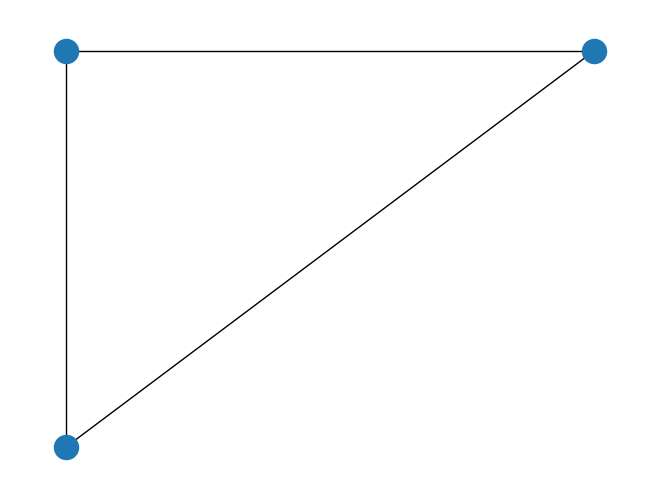

In [13]:
# 기초 프로세스
import networkx as nx 
import matplotlib.pyplot as plt

# 그래프 객체 생성
G = nx.Graph()

# 노드 설정(점)
G.add_node('nodeA')
G.add_node('nodeB')
G.add_node('nodeC')

# 엣지 설정(선)
G.add_edge('nodeA', 'nodeB')
G.add_edge('nodeA', 'nodeC')
G.add_edge('nodeB', 'nodeC')

# 좌표 설정
pos = {}
pos['nodeA'] = (0, 0)
pos['nodeB'] = (1, 1)
pos['nodeC'] = (0, 1)

# 그리기 
nx.draw(G,pos)

# 표시
plt.show()

먼저 그래프 객체를 선언하고 노드 A,B,C와 각각 연결할 엣지를 설정합니다. 다음으로 노드의 좌표를 설정하고 함수 draw를 이용해서 그립니다. 마지막으로 matplotlib의 show를 이용해서 화면에 표시합니다. 이런 흐름으로 네트워크를 가시화해서 창고에서 대리점까지의 물류를 표현할 수 있습니다. 네트워크를 가시화하면 숫자만으로 알기 어려운 물류의 쏠림과 같은 전체 그림을 파악할 수 있습니다.

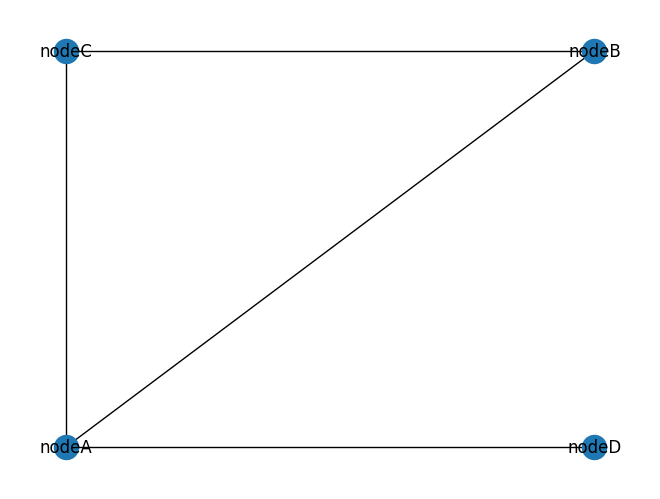

In [14]:
# 노드 추가
# 순서 : node(점), edge(선), 좌표(pos) pos = {}

G.add_node('nodeD')

G.add_edge('nodeA', 'nodeD')

pos['nodeD'] = (1, 0)

nx.draw(G, pos, with_labels= True)

>> 경로 가중치 부여

가중치를 이용해서 노드 사이 엣지 굵기를 바꾸면 최적 경로를 알기 쉽게 가시화할 수 있습니다. 여기서는 CSV 파일에 저장된 가중치 정보를 데이터프레임으로 읽어 들여 그 값을 사용하는 방법을 이용합니다.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 

In [25]:
df_weight = pd.read_csv('./data/network_weight.csv')
df_weight

df_pos = pd.read_csv('./data/network_pos.csv')
df_pos.head()


,A,B,C,D,E
0,0,0,2,2,1
1,0,2,0,2,1


In [ ]:
G = nx.Graph()

# 노드 설정
for i in range(len(df_weight.columns)) :
  G.add_node(df_weight.columns[i])

size = 10
# 엣지 설정 + 가중치 부여
for i in range(len(df_weight.columns)) :
  for j in range(i + 1, len(df_weight.columns)) : # 중복 방지
    node1 = df_weight.columns[i]
    node2 = df_weight.columns[j]
    weight = df_weight.iloc[i, j] * size
    G.add_edge(node1, node2, weight = weight)

# 좌표 설정
pos = {node : (df_pos[node][0], df_pos[node][1]) for node in df_pos.columns}

# 엣지 가중치 추출
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# 그리기
nx.draw(G, pos, with_labels = True, 
        font_size = 16, node_size= 1000, node_color= 'k', font_color = 'w', width= edge_weights)

# 표시 
plt.show()


In [ ]:
df_weight
df_pos

G = nx.Graph()

for i in range(len(df_weight.columns)) :
  G.add_node(df_weight.columns[i])

for i in range(len(df_weight.columns)) :
  for j in range(len(df_weight.columns)) :
    node1 = df_weight.columns[i]
    node2 = df_weight.columns[j]
    weight = df_weight.iloc[i][j]
    G.add_edge(node1, node2, weight= weight)

pos = {node : (df_pos[node][0], df_pos[node][1]) for node in df_weight.columns}

edge_weights = [G[u][v][weight] for u, v in G.edges()]

